In [28]:
import sympy as sp
from sympy.geometry import * 
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, Latex
from sympy import init_printing

# Definition of test triangle

In [29]:
# points
p0 = sp.Matrix([sp.S(0), sp.S(0)])
p1 = sp.Matrix([sp.S(1), sp.S(0)])
p2 = sp.Matrix([sp.S(-0.2), sp.S(1)])
p3 = sp.Matrix([sp.S(-1), sp.Rational(1, 2)])

all_points = [p0, p1, p2, p3]

# triangles
triangle_1 =[p0, p1, p2]
triangle_2 =[p0, p2, p3]

# normal for side [p0, p2]
n1 = - sp.Matrix([sp.S(1), sp.S(0.2)])

Quick plot of configuration:

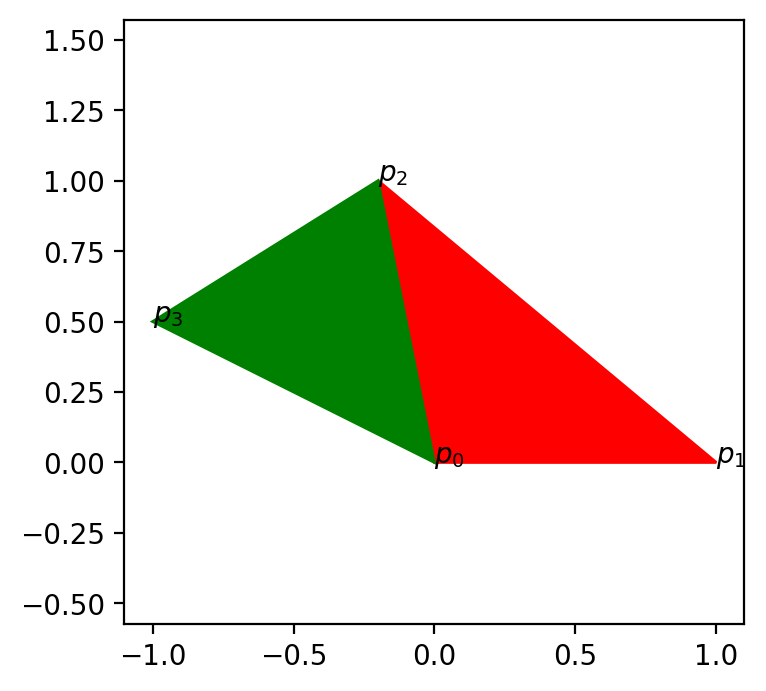

In [30]:
%matplotlib inline

def to_polygon(triangle, **kwargs):
    return plt.Polygon(np.array([t.transpose().tolist()[0] for t in triangle]), **kwargs)  

labels = [r'$p_0$',r'$p_1$',r'$p_2$',r'$p_3$']

fig, ax = plt.subplots(figsize=(4,4), dpi=200)
for i, an in enumerate(labels):
    plt.annotate(an, (all_points[i][0], all_points[i][1]))
plt.gca().add_patch(to_polygon(triangle_1, color='red'))
plt.gca().add_patch(to_polygon(triangle_2, color='green'))
ax.axis('equal')
plt.show()


# Shape functions definition in reference domain

Coordinates:

In [31]:
x, y = sp.symbols('x y')

Test functions in reference space:

In [32]:
phi0_hat = 1-x-y
phi1_hat = x
phi2_hat = y
phi_i_hat = phi0_hat, phi1_hat, phi2_hat

Vectorial DG basis function:

In [33]:
def get_edg_basis(p0, p1, p2):
    """Returns the additional vectorial shape function"""
    phi_vec = sp.Matrix([x, y]) - sp.Matrix([p0[0] + p1[0] + p2[0], p0[1] + p1[1] + p2[1]]) / sp.S(3)
    return phi_vec

Vectorial DG basis function in reference space:

In [34]:
phi_edg_hat = get_edg_basis(p0, p1, sp.Matrix([0, 1]))
phi_i_hat = phi_edg_hat, phi0_hat, phi1_hat, phi2_hat

# Shape function definition on transformed triangle

In [35]:
def get_affine_trafo(p0, p1, p2):
    """
    Calculates the affine transformation from the reference triangle
    to the triangle given by (p0, p1, p2)
    """
    A1 = sp.Matrix([(p1 - p0).transpose().tolist()[0], (p2 - p0).transpose().tolist()[0]]).transpose()
    #print("A in get_affine_trafo:" + str(A1))   
    b1 = p0
    return A1, b1

def get_basis(p0, p1, p2):
    """Returns the P1 basis on the triangle (p0, p1, p2)."""
    A1, b1 = get_affine_trafo(p0, p1, p2)
    A1_inv = A1.inv()
    to_hat = A1_inv * (sp.Matrix([x, y]) - b1)
    x_hat,y_hat = sp.symbols(r'\hat{x} \hat{y}')
    phi0 = phi0_hat.subs(zip([x,y], [x_hat, y_hat])).subs(zip([x_hat,y_hat], to_hat))
    phi1 = phi1_hat.subs(zip([x,y], [x_hat, y_hat])).subs(zip([x_hat,y_hat], to_hat))
    phi2 = phi2_hat.subs(zip([x,y], [x_hat, y_hat])).subs(zip([x_hat,y_hat], to_hat))
    return [phi0, phi1, phi2]

Shape functions in affine space first triangle

In [36]:
phi0_t1, phi1_t1, phi2_t1 = get_basis(p0, p1, p2)
phi_edg_t1 = get_edg_basis(p0, p1, p2)

print(phi_edg_t1)
phi_t1 = phi_edg_t1, phi0_t1, phi1_t1, phi2_t1
print(phi_edg_t1)

Matrix([[x - 0.266666666666667], [y - 1/3]])
Matrix([[x - 0.266666666666667], [y - 1/3]])


Shape functions in affine space second triangle

In [37]:
phi_0_t2, phi_2_t2, phi_3_t2 = get_basis(p0, p2, p3)
phi_edg_t2 = get_edg_basis(p0, p2, p3)
phi_t2 = phi_edg_t2, phi_0_t2, phi_2_t2, phi_3_t2

Affine transformation

In [38]:
A, b = get_affine_trafo(p0, p1, p2)
A_inv = A.inv()

Short sanity check: is our transformation correct?
I.e. is
$$ A * \hat \phi_{edg} ( A^{-1} ( x - b ) ) = \phi_{edg} ( x ) $$

In [39]:
A * phi_edg_hat.subs(zip([x,y],A_inv*(sp.Matrix([x,y]) -b ))) == phi_edg_t1

True

Unit vectors:

In [40]:
e0 = sp.Matrix([1, 0])
e1 = sp.Matrix([0, 1])

1D integration variable $\xi$:

In [41]:
xi = sp.symbols(r'\xi')

In [42]:
def integrate_form(form, p2, p0):
    """Integrates the form in (x,y) coordinates along the path p0, p2"""
    line_length = (p2 - p0).norm()
    form1d = form.subs(zip([x,y], (p2 - p0)/sp.S(2)* xi + (p2 + p0)/sp.S(2)))
    nodes = [sp.S(0), -sp.sqrt(sp.Rational(3,5)), +sp.sqrt(sp.Rational(3,5))]
    weights = [sp.Rational(8, 9), sp.Rational(5, 9), sp.Rational(5, 9)]
    su = sp.S(0)
    for n,w in zip(nodes, weights):
        su += w *form1d.subs(xi, n)
    return su * (line_length/2)



In [43]:
def nabla_vec(phi):
    """Calculates the jacobi matrix for a vectorial shape function"""
    return sp.Matrix([[phi[0].diff(x), phi[0].diff(y)],
                     [phi[1].diff(x), phi[1].diff(y)]])

Sanity check do our transformations work?
We integrate
$$ \int_{(p_0,p_2)} (\nabla \left( \phi_0 \begin{bmatrix} 1 \\ 0 \end{bmatrix} \right)n_1) \cdot \phi_{edg} dx$$
on $(p_0, p_2)$ and compute
$$ |e|\int_{(\hat{p}_0, \hat{p}_2)}(\hat{\nabla} \left(\hat{\phi}_0 \begin{bmatrix} 1 \\ 0 \end{bmatrix}\right)  A^{-1}n_1) \cdot A\hat{\phi}_{edg} d\hat{x}$$ 
on $(\hat p_0, \hat p_2)$ and compare the results

In [44]:
# integral in the affine space
result_affine = integrate_form((nabla_vec(phi0_t1 * e0) * n1).dot(phi_edg_t1), p2, p0)
# integral in the reference space
result_transformed = integrate_form(
    (nabla_vec(phi0_hat * e0) * A_inv  * n1).dot(A * phi_edg_hat), sp.Matrix([0,1]), p0) * (p2-p0).norm()
sp.Abs(result_affine - result_transformed) < 1e-15

True

In [45]:
# integral in the affine space
result_affine = integrate_form((nabla_vec(phi_edg_t1) * n1).dot(phi0_t1 * e0), p2, p0)
# integral in the reference space
result_transformed = integrate_form(
    (nabla_vec(A * phi_edg_hat) * A_inv  * n1).dot(phi0_hat * e0), sp.Matrix([0,1]), p0) * (p2-p0).norm()
sp.Abs(result_affine - result_transformed) < 1e-15

True

# Consistency and Symmetry

Consistency and symmetry terms of SIPG are
$$ - \int_e \left(\{ \nabla u \} \cdot n \right) \, [v] + [u] \, \left(\{ \nabla v \} \cdot n\right) ds $$
for a trial function $u$ and test function $v$.

Expanding them gives:
$$ \begin{aligned} \left(\{ \nabla u \} \cdot n \right) \, [v] + [u] \, \left(\{ \nabla v \} \cdot n\right) =& \frac{1}{2} (
 (\nabla u^+ \cdot n^+) v^+
 - (\nabla u^+ \cdot n^+) v^-
 +
  (\nabla u^- \cdot n^+) v^+
 - (\nabla u^- \cdot n^+) v^-
\\
& \quad
 + (\nabla v^+ \cdot n^+) u^+
 - (\nabla v^+ \cdot n^+) u^-
 +
  (\nabla v^- \cdot n^+) u^+
 - (\nabla v^- \cdot n^+) u^-
 )
\end{aligned}
$$
We have to assemble the contributions to $v^+$, i.e.
$$
\frac{1}{2} 
 \left((\nabla u^+ \cdot n^+) v^+
 + (\nabla u^- \cdot n^+) v^+
 + (\nabla v^+ \cdot n^+) u^+
 - (\nabla v^+ \cdot n^+) u^-
 \right)
$$
The "inner" contributions are therefore
$$
\frac{1}{2} 
 \left((\nabla u^+ \cdot n^+) v^+
 + (\nabla v^+ \cdot n^+) u^+
 \right)
$$
and the "outer" contributions
$$
\frac{1}{2} \left(
 (\nabla u^- \cdot n^+) v^+
 - (\nabla v^+ \cdot n^+) u^-
 \right)
$$



In [46]:
def symmetry_and_consistency_inner(u, v):
    consistency = - 0.5 * integrate_form((nabla_vec(u) * n1).dot(v), p2, p0)
    symmetry = - 0.5 * integrate_form((nabla_vec(v) * n1).dot(u), p2, p0)
    return consistency + symmetry

def symmetry_and_consistency_outer(u, v):
    consistency = - 0.5 * integrate_form((nabla_vec(u) * n1).dot(v), p2, p0)
    symmetry = + 0.5 * integrate_form((nabla_vec(v) * n1).dot(u), p2, p0)
    return consistency + symmetry
    
def symmetry_outer(u, v):
    return + 0.5 * integrate_form((nabla_vec(v) * n1).dot(u), p2, p0)

def consistency_outer (u, v):
    return - 0.5 * integrate_form((nabla_vec(u) * n1).dot(v), p2, p0)


# Penalty
Penalty terms of the SIPG are
$$ \frac{\sigma}{|e|} \int_e [u] \cdot [v] ds $$
for a trial function $u$ and test function $v$.
Expanding them gives:
$$ [u] \cdot [v] = u^+ \cdot v^+- u^- \cdot v^+- u^+ \cdot v^-+ u^- \cdot v^- $$
We have to assemble the contributions to $v^+$, i.e.
$$\frac{1}{|e|} \left( u^+ \cdot v^+- u^- \cdot v^+ \right) $$
The "inner" contributions are therefore
$$\frac{1}{|e|} u^+ \cdot v^+ $$
and the outer contribution is
$$- \frac{1}{|e|} u^- \cdot v^+ $$


In [47]:
def penalty_inner(u, v):
    return integrate_form(u.dot(v), p2, p0) / (p2 - p0).norm()

def penalty_outer(u, v):
    return - integrate_form(u.dot(v), p2, p0) / (p2 - p0).norm()

In [48]:
[-symmetry_and_consistency_inner(phi_t1[i] * e0, phi_t1[j]* e0) for i in range(1,4) for j in range(1,4)]

[0.632278419685505,
 -0.265149014706825,
 0.265149014706825,
 -0.265149014706825,
 0,
 -0.265149014706825,
 0.265149014706825,
 -0.265149014706825,
 -0.101980390271856]

In [49]:
[float(penalty_inner(phi_t1[i] * e0, phi_t1[j]* e0)) for i in range(1,4) for j in range(1,4)]

[0.33333333333333337,
 0.0,
 0.1666666666666667,
 0.0,
 0.0,
 0.0,
 0.1666666666666667,
 0.0,
 0.3333333333333333]

Test values **P1-to-EDG** *inner* coupling

In [50]:
[symmetry_and_consistency_inner(phi_t1[i] * e0, phi_edg_t1) for i in range(1,4)]

[0.486786396230991, -0.194442610785005, 0.217558165913292]

In [51]:
[float(penalty_inner(phi_t1[i] * e0, phi_edg_t1)) for i in range(1,4)]

[-0.16666666666666674, 0.0, -0.2]

Test values **P1-to-EDG** *outer* coupling

In [52]:
[symmetry_and_consistency_outer(phi_t2[i] * e0, phi_edg_t1) for i in range(1,4)]

[-0.325581838571628, -0.400367458104322, 0.216047345316672]

In [53]:
[float(penalty_outer(phi_t2[i] * e0, phi_edg_t1)) for i in range(1,4)]

[0.16666666666666666, 0.2, 0.0]

Test values **EDG-EDG** *inner* coupling

In [54]:
symmetry_and_consistency_inner(phi_edg_t1, phi_edg_t1)

-0.339934634239519

In [55]:
float(penalty_inner(phi_edg_t1, phi_edg_t1))

0.24888888888888894

Test values **EDG-EDG** *outer* coupling

In [56]:
symmetry_and_consistency_outer(phi_edg_t2, phi_edg_t1)

-0.322937902527543

In [57]:
float(penalty_outer(phi_edg_t2, phi_edg_t1))

0.02333333333333332

# DivT and Pressure

Basis function $P^0$ pressure space:

In [58]:
psi = sp.S(1)

The transposed divergence term has the form
$$ \int_e \{p\}[v] \cdot n_e ds $$
for trial function $p$ and test function $v$.
Thus
$$ \{p\}[v] = \frac{1}{2}(p^+ v^+ + p^- v^+ - p^+ v^- - p^- v^- ) n^+ $$
We have to assemble the contributions $v^+$, i.e.
$$ \frac{1}{2}(p^+ v^+ + p^- v^+ ) n^+ $$
The "inner" contribution
$$ \frac{1}{2}p^+ v^+ n^+$$
and the outer contribution is
$$ \frac{1}{2}p^- v^+ n^+$$

In [59]:
def divt(p, v):
    return 0.5 * integrate_form(v.dot(n1) * p, p2, p0)

Test values **P1-P0** *inner* and *outer*:

In [60]:
[divt(psi, phi_t1[i]*e0) for i in range(1,4)]

[-0.254950975679639, 0, -0.254950975679639]

Test values **EDG-P0** *inner* and *outer*

In [61]:
divt(psi, phi_edg_t1)

0.169967317119760

# Div 
The divergence term has the form
$$ \int_e \{q\}[u] \cdot n_e ds $$
for trial function $u$ and test function $q$.
Thus
$$ \{q\}[u] = \frac{1}{2}(q^+ u^+ + q^- u^+ - q^+ u^- - q^- u^- ) n^+ $$
We have to assemble the contributions $q^+$, i.e.
$$ \frac{1}{2}(q^+ u^+ - q^+ u^-) n^+ $$
The "inner" contribution
$$ \frac{1}{2}q^+ u^+ n^+$$
and the outer contribution is
$$ -\frac{1}{2}q^+ u^- n^+$$

In [62]:
def div_inner(u, q):
    return 0.5 * integrate_form(u.dot(n1) * q, p2, p0)

def div_outer(u, q):
    return -0.5 * integrate_form(u.dot(n1) * q, p2, p0)

Test values **P0-P1** *inner*:

In [63]:
[div_inner(phi_t1[i]*e0, psi) for i in range(1,4)]

[-0.254950975679639, 0, -0.254950975679639]

Test values **P0-EDG** *inner*:

In [64]:
div_inner(phi_edg_t1, psi)

0.169967317119760

Test values **P0-P1** *outer*:

In [65]:
[div_outer(phi_t2[i]*e0, psi) for i in range(1,4)]

[0.254950975679639, 0.254950975679639, 0]

Test values **P0-EDG** *outer*:

In [66]:
div_outer(phi_edg_t2, psi)

0.152970585407784

# Edge integrals with $\epsilon()$
The symmetric gradient $\epsilon()$ is defined as 
    $$\begin{align}
    \epsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^T)
    \end{align}$$

In [67]:
def epsilon(phi):
    """Calculates the symmetric gradient for a vectorial shape function"""
    gradient = sp.Matrix([[phi[0].diff(x), phi[0].diff(y)],
                     [phi[1].diff(x), phi[1].diff(y)]])
    return 0.5*(gradient + sp.transpose(gradient))

The following 
Consistency and symmetry terms of SIPG with epsilon operator are
$$ - \int_e \left(\{ \epsilon(u) \} \cdot n \right) \, [v] + [u] \, \left(\{  \epsilon(v) \} \cdot n\right) ds $$
for a trial function $u$ and test function $v$.

Expanding them gives:
$$ \begin{aligned} \left(\{  \epsilon(u) \} \cdot n \right) \, [v] + [u] \, \left(\{  \epsilon(v) \} \cdot n\right) =& \frac{1}{2} (
 ( \epsilon(u)^+ \cdot n^+) v^+
 - (v^+ \cdot n^+) v^-
 +
  ( \epsilon(u)^- \cdot n^+) v^+
 - ( \epsilon(u)^- \cdot n^+) v^-
\\
& \quad
 + ( \epsilon(v)^+ \cdot n^+) u^+
 - (\epsilon(v)^+ \cdot n^+) u^-
 +
  (\epsilon(v)^- \cdot n^+) u^+
 - (\epsilon(v)^- \cdot n^+) u^-
 )
\end{aligned}
$$
We have to assemble the contributions to $v^+$, i.e.
$$
\frac{1}{2} 
 \left((\epsilon(u)^+ \cdot n^+) v^+
 + (\epsilon(u)^- \cdot n^+) v^+
 + (\epsilon(v)^+ \cdot n^+) u^+
 - (\epsilon(v)^+ \cdot n^+) u^-
 \right)
$$
The "inner" contributions are therefore
$$
\frac{1}{2} 
 \left((\epsilon(u)^+ \cdot n^+) v^+
 + (\epsilon(v)^+ \cdot n^+) u^+
 \right)
$$
and the "outer" contributions
$$
\frac{1}{2} \left(
 (\epsilon(u)^- \cdot n^+) v^+
 - (\epsilon(v)^+ \cdot n^+) u^-
 \right)
$$


In [68]:
def symmetry_and_consistency_inner_eps(u, v):
    consistency = - 0.5 * integrate_form((epsilon(u) * n1).dot(v), p2, p0)
    symmetry = - 0.5 * integrate_form((epsilon(v) * n1).dot(u), p2, p0)
    return consistency + symmetry

def symmetry_and_consistency_outer_eps(u, v):
    consistency = - 0.5 * integrate_form((epsilon(u) * n1).dot(v), p2, p0)
    symmetry = + 0.5 * integrate_form((epsilon(v) * n1).dot(u), p2, p0)
    return consistency + symmetry
    
def symmetry_outer_eps(u, v):
    return + 0.5 * integrate_form((epsilon(v) * n1).dot(u), p2, p0)

def consistency_outer_eps(u, v):
    return - 0.5 * integrate_form((epsilon(u) * n1).dot(v), p2, p0)

Precalculating the terms of the weak formulation with edge integrals and $\epsilon$: \
Test values **P1-to-EDG** *inner* coupling

In [74]:
[symmetry_and_consistency_inner_eps(phi_t1[i] * e0, phi_edg_t1) for i in range(1,4)]

[0.413360515235255, -0.182204963952382, 0.278746400076406]

Test values **P1-to-EDG** *outer* coupling

In [78]:
[symmetry_and_consistency_outer_eps( phi_t1[i] * e0, phi_edg_t2) for i in range(1,4)]

[-0.426278031336357, 0.156029997115939, -0.239653917138861]

Test values **EDG-EDG** *inner* coupling

In [195]:
symmetry_and_consistency_inner_eps(phi_edg_t1, phi_edg_t1)

-0.339934634239519

Test values **EDG-EDG** *outer* coupling

In [196]:
symmetry_and_consistency_outer_eps(phi_edg_t2, phi_edg_t1)

-0.322937902527543

# Volume integrals with $\epsilon()$

In the enriched Galerkin scheme, both u and v are linear functions, such that the product of their symmetric gradients is constant. Therefore, taking the function value together with the area of the given triangle integrates the product exactly.

In [140]:
def integrate_constant_form_triangle(form, a0, a1, a2):
    return  form*Triangle(a0, a1, a2).area

The volume integral over triangle $T$ that stems from the diffusion term is given by:
$$
\begin{aligned}
    \int_T \epsilon(u):\epsilon(v)
\end{aligned}
$$


Check if the integration on the affine and the reference space matches (with $\phi$ defined on triangle 1, $\hat{\phi}$ defined on the reference triangle):
$$ \begin{align}
     \int_T \epsilon(\phi_{edg}): \epsilon(\phi_i) 
        &\stackrel{!}{=} 2 |T| \int_{\hat{T}} \hat{\epsilon}(A\hat{\phi}_{edg}):\hat{\epsilon}(\hat{\phi}_{i}) \quad \text{(map basis functions to $\hat{T}, \phi_{edg}$ needs additional $A$) }\\
    &=  \frac{|T|}{2} \int_{\hat{T}} (\hat{\nabla} (A\hat{\phi}_{edg})A^{-1} +A^{-T}\hat{\nabla}(A\hat{\phi}_{edg})^T):(\hat{\nabla}(\hat{\phi}_{i})A^{-1} + A^{-T}\hat{\nabla}(\hat{\phi}_{i})^T)  \\
\text{with: i = 0,1,2,edg}\\
\end{align} $$

In [141]:
# implements : operator
def double_contraction(mat_1, mat_2):
    return sp.Matrix([[1,1]])*sp.matrix_multiply_elementwise(mat_1,mat_2)*sp.Matrix([[1],[1]])

In [142]:
# for nice output
def print_basis_idx(i):
    if i == 0:
        return "{edg}"
    else:
        return i

In [143]:
# choose basis function and triangle points
def choose_basis(i, triangle):
    pt0 = p0
    basis_idx = print_basis_idx(i)
    if triangle == 1:
        pt1 = p1
        pt2 = p2
        phi_i = phi_t1[i]
        phi_edg_t = phi_edg_t1
    elif triangle == 2:
        pt1 = p2
        pt2 = p3
        phi_i = phi_t2[i]
        phi_edg_t = phi_edg_t2
    return phi_edg_t, phi_i, pt0, pt1, pt2

In [147]:
# evaluate integral in affine space
def evaluate_affine(phi_edg_t, phi_i, i, pt0, pt1, pt2, triangle):
   if i == 0:
        form_affine = double_contraction(epsilon(phi_edg_t),epsilon(phi_i)) # phi_edg is already vectorial
   else:
        form_affine = double_contraction(epsilon(phi_edg_t),epsilon(phi_i * e0))
    
   result_affine = integrate_constant_form_triangle(form_affine, pt0, pt1, pt2)  
   display(Latex(f'On triangle {triangle}: $\int_T \epsilon(\phi_{{edg}}) : \epsilon(\phi_{ print_basis_idx(i)}) =  {result_affine[0]}$'))
   return result_affine

# evaluate integral in reference space
def evaluate_reference(phi_edg_t, phi_i, i, pt0, pt1, pt2, triangle):
    A, b = get_affine_trafo(pt0, pt1, pt2)
    A_inv = A.inv()
    #grad_phi_edg = A_inv.T*A*nabla_vec(phi_edg_hat)
    
    # gradients in reference space
    grad_phi_edg = A*nabla_vec(phi_edg_hat)*A_inv
    # case distinction: basis is edg or not: add A*
    if(i == 0):
    #    grad_phi_i = A_inv.T*nabla_vec(A*phi_i_hat[i])
        grad_phi_i = nabla_vec(A*phi_i_hat[i])*A_inv  
    else:
    #    grad_phi_i = A_inv.T*nabla_vec(phi_i_hat[i]*e0)
        grad_phi_i = nabla_vec(phi_i_hat[i]*e0)*A_inv
        
    # form in reference space
    form_reference = double_contraction(grad_phi_edg + sp.Transpose(grad_phi_edg), grad_phi_i + sp.Transpose(grad_phi_i))
    
    # integration in reference
    result_reference = integrate_constant_form_triangle(form_reference, p0, e0, e1) * 0.5 * Triangle(pt0, pt1, pt2).area
    print(result_reference)
    
    display(Latex(f'On triangle {triangle} (Reference): $2 |T| \int_{{\hat{{T}}}} \hat{{\epsilon}}(A\hat{{\phi}}_{{edg}}):\hat{{\epsilon}}(\hat{{\phi_{ print_basis_idx(i)}}})  =  {result_reference[0]}$'))
    return result_reference

# checks int_T eps(phi_edg) : eps(phi_i), reference vs affine for phi_edg, phi_i pairings, i = 0,1,2,edg
def check_volume_int(i, triangle):
    
    # points of chosen triangle, basis on chosen triangle
    phi_edg_t, phi_i, pt0, pt1, pt2, = choose_basis(i, triangle)
    
    
    # integral in the affine space
    result_affine = evaluate_affine(phi_edg_t, phi_i, i, pt0, pt1, pt2, triangle)
    print(result_affine)

    # integral in the reference space
    result_reference = evaluate_reference(phi_edg_t, phi_i, i, pt0, pt1, pt2, triangle)
    print(result_reference)
    
    # check if they match
    print("Match: " + str(abs(result_affine.norm() - result_transformed) < 1e-15))

In [149]:
[check_volume_int(i, t) for t in range(1,3) for i in range(1)] # check volume integral for all basis functions and triangles

<IPython.core.display.Latex object>

Matrix([[1.00000000000000]])
Matrix([[1.00000000000000]])


<IPython.core.display.Latex object>

Matrix([[1.00000000000000]])
Match: False


<IPython.core.display.Latex object>

Matrix([[0.900000000000000]])
Matrix([[0.900000000000000]])


<IPython.core.display.Latex object>

Matrix([[0.900000000000000]])
Match: False


[None, None]